Before process_an_example(reactionSmartsString):


RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 14 15 16 19 20 25
RDKit ERROR: 
RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 14 15 16 19 20 25
RDKit ERROR: 
RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 14 15 16 19 20 25
RDKit ERROR: 
RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 14 15 16 19 20 25
RDKit ERROR: 


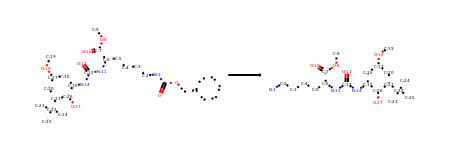

After process_an_example(reactionSmartsString):


RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [23:31:45] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9
RDKit ERROR: 


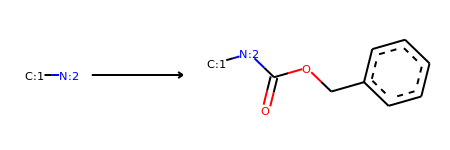

In [1]:
'''
This script (generate_reaction_templates) uses a MongoDB collection 
with atom-mapped reaction SMILES strings and parses them into a new 
collection containing the transforms.

This is intended to be used with the Reaxys database. In the database,
reagents can contribute atoms to the products. This means that those
atoms are not mapped in the RXN_SMILES field. The script currently
leaves those atoms OUT of the template.

As an example, halogenation might be performed using [Cl][Cl] as a
chlorinating agent, so the chlorine atom in the product will be 
unmapped. This script will create a retrosynthetic template that does
not included a specific precursor containing a Cl atom. Instead, an
extra field is added to the template document indicating that there 
is a necessary_reagent fragment (as a generalized SMARTS string).

Additionally, in the cases of unmapped product atoms, those atoms are
FULLY specified in the product fragment

v4 uses a parallel worker pool with a generator that queues up 10,000
     reactions at a time

v5  - requires that instance references be single-step, but they
     CAN be multi-stage since stages are usually very minor order of
     addition issues (but one-pot)
    - only includes reactions with a RX_MAXPUB >= 1940. Note that older
     papers may be used as examples (RXDs, or instances), but the 
     reaction itself, defined by reactants and products, must have a
     somewhat recent example.
    - Keeps track of reaction templates that arise from intramolecular
     reactions and adds a field to the template doc so that we can
     enforce that rerstriction during template application
'''

from __future__ import print_function
USE_STEREOCHEMISTRY = True
import argparse
from numpy.random import shuffle # for random selection
import rdkit.Chem as Chem          # molecule building
from rdkit.Chem import AllChem
from collections import defaultdict
import rdkit.Chem.Draw as Draw
from rdkit import RDLogger
import datetime # for info files
import json # for dumping
import sys  # for commanad line
import os   # for file paths
import re 
import itertools
from tqdm import tqdm 
v = False

def mols_from_smiles_list(all_smiles):
    '''Given a list of smiles strings, this function creates rdkit
    molecules'''
    mols = []
    for smiles in all_smiles:
        if not smiles: continue
        mols.append(Chem.MolFromSmiles(smiles))
    return mols

def bond_to_label(bond):
    '''This function takes an RDKit bond and creates a label describing
    the most important attributes'''
    # atoms = sorted([atom_to_label(bond.GetBeginAtom().GetIdx()), \
    #               atom_to_label(bond.GetEndAtom().GetIdx())])
    a1_label = str(bond.GetBeginAtom().GetAtomicNum())
    a2_label = str(bond.GetEndAtom().GetAtomicNum())
    if bond.GetBeginAtom().HasProp('molAtomMapNumber'):
        a1_label += bond.GetBeginAtom().GetProp('molAtomMapNumber')
    if bond.GetEndAtom().HasProp('molAtomMapNumber'):
        a2_label += bond.GetEndAtom().GetProp('molAtomMapNumber')
    atoms = sorted([a1_label, a2_label])

    return '{}{}{}'.format(atoms[0], bond.GetSmarts(), atoms[1])

def get_tagged_atoms_from_mols(mols):
    '''Takes a list of RDKit molecules and returns total list of
    atoms and their tags'''
    atoms = []
    atom_tags = []
    for mol in mols:
        new_atoms, new_atom_tags = get_tagged_atoms_from_mol(mol)
        atoms += new_atoms 
        atom_tags += new_atom_tags
    return atoms, atom_tags

def get_tagged_atoms_from_mol(mol):
    '''Takes an RDKit molecule and returns list of tagged atoms and their
    corresponding numbers'''
    atoms = []
    atom_tags = []
    for atom in mol.GetAtoms():
        if atom.HasProp('molAtomMapNumber'):
            atoms.append(atom)
            atom_tags.append(str(atom.GetProp('molAtomMapNumber')))
    return atoms, atom_tags

def atoms_are_different(atom1, atom2):
    '''Compares two RDKit atoms based on basic properties'''

    if atom1.GetSmarts() != atom2.GetSmarts(): return True # should be very general
    if atom1.GetAtomicNum() != atom2.GetAtomicNum(): return True # must be true for atom mapping
    if atom1.GetTotalNumHs() != atom2.GetTotalNumHs(): return True
    if atom1.GetFormalCharge() != atom2.GetFormalCharge(): return True
    if atom1.GetDegree() != atom2.GetDegree(): return True
    #if atom1.IsInRing() != atom2.IsInRing(): return True
    if atom1.GetNumRadicalElectrons() != atom2.GetNumRadicalElectrons(): return True
    if atom1.GetIsAromatic() != atom2.GetIsAromatic(): return True 
    # TODO: add # pi electrons like ICSynth?

    # Check bonds and nearest neighbor identity
    bonds1 = sorted([bond_to_label(bond) for bond in atom1.GetBonds()]) 
    bonds2 = sorted([bond_to_label(bond) for bond in atom2.GetBonds()]) 
    if bonds1 != bonds2: return True

        # # Check neighbors too (already taken care of with previous lines)
        # neighbors1 = sorted([atom.GetAtomicNum() for atom in atom1.GetNeighbors()])
        # neighbors2 = sorted([atom.GetAtomicNum() for atom in atom2.GetNeighbors()])
        # if neighbors1 != neighbors2: return True

    # print('bonds1: {}'.format(bonds1))
    # print('bonds2: {}'.format(bonds2))

    return False

def get_changed_atoms(reactants, products):
    '''Looks at mapped atoms in a reaction and determines which ones changed'''

    err = 0
    prod_atoms, prod_atom_tags = get_tagged_atoms_from_mols(products)

    if v: print('Products contain {} tagged atoms'.format(len(prod_atoms)))
    if v: print('Products contain {} unique atom numbers'.format(len(set(prod_atom_tags))))

    reac_atoms, reac_atom_tags = get_tagged_atoms_from_mols(reactants)
    if len(set(prod_atom_tags)) != len(set(reac_atom_tags)):
        if v: print('warning: different atom tags appear in reactants and products')
        #err = 1 # okay for Reaxys, since Reaxys creates mass
    if len(prod_atoms) != len(reac_atoms):
        if v: print('warning: total number of tagged atoms differ, stoichometry != 1?')
        #err = 1

    # Find differences 
    changed_atoms = []
    changed_atom_tags = []
    #print(reac_atom_tags)
    #print(prod_atom_tags)

    # Product atoms that are different from reactant atom equivalent
    for i, prod_tag in enumerate(prod_atom_tags):

        for j, reac_tag in enumerate(reac_atom_tags):
            if reac_tag != prod_tag: continue
            if reac_tag not in changed_atom_tags: # don't bother comparing if we know this atom changes
                # If atom changed, add
                if atoms_are_different(prod_atoms[i], reac_atoms[j]):
                    changed_atoms.append(reac_atoms[j])
                    changed_atom_tags.append(reac_tag)
                    break
                # If reac_tag appears multiple times, add (need for stoichometry > 1)
                if prod_atom_tags.count(reac_tag) > 1:
                    changed_atoms.append(reac_atoms[j])
                    changed_atom_tags.append(reac_tag)
                    break

    # Reactant atoms that do not appear in product (tagged leaving groups)
    for j, reac_tag in enumerate(reac_atom_tags):
        if reac_tag not in changed_atom_tags:
            if reac_tag not in prod_atom_tags:
                changed_atoms.append(reac_atoms[j])
                changed_atom_tags.append(reac_tag)

    # Changed CHIRALITY atoms (just tetra for now...)
    tetra_atoms = get_tetrahedral_atoms(reactants, products)
    if v:
        print('Found {} atom-mapped tetrahedral atoms that have chirality specified at least partially'.format(len(tetra_atoms)))
    [set_isotope_to_equal_mapnum(reactant) for reactant in reactants]
    [set_isotope_to_equal_mapnum(product) for product in products]
    for (atom_tag, ar, ap) in tetra_atoms:
        if v: 
            print('For atom tag {}'.format(atom_tag))
            print('    reactant: {}'.format(ar.GetChiralTag()))
            print('    product:  {}'.format(ap.GetChiralTag()))
        if atom_tag in changed_atom_tags:
            if v:
                print('-> atoms have changed (by more than just chirality!)')
        else:
            from rdkit.Chem.rdchem import ChiralType
            unchanged = check_tetrahedral_centers_equivalent(ar, ap) and \
                    ChiralType.CHI_UNSPECIFIED not in [ar.GetChiralTag(), ap.GetChiralTag()]
            if unchanged:
                if v: 
                    print('-> atoms confirmed to have same chirality, no change')
            else:
                if v:
                    print('-> atom changed chirality!!')
                # Make sure chiral change is next to the reaction center and not
                # a random specifidation (must be CONNECTED to a changed atom)
                tetra_adj_to_rxn = False
                for neighbor in ap.GetNeighbors():
                    if neighbor.HasProp('molAtomMapNumber'):
                        if neighbor.GetProp('molAtomMapNumber') in changed_atom_tags:
                            tetra_adj_to_rxn = True
                            break
                if tetra_adj_to_rxn:
                    if v:
                        print('-> atom adj to reaction center, now included')
                    changed_atom_tags.append(atom_tag)
                    changed_atoms.append(ar)
                else:
                    if v:
                        print('-> adj far from reaction center, not including')
    [clear_isotope(reactant) for reactant in reactants]
    [clear_isotope(product) for product in products]



    if v: 
        print('{} tagged atoms in reactants change 1-atom properties'.format(len(changed_atom_tags)))
        for smarts in [atom.GetSmarts() for atom in changed_atoms]:
            print('  {}'.format(smarts))

    return changed_atoms, changed_atom_tags, err

def expand_atoms_to_use(mol, atoms_to_use, groups=[], symbol_replacements=[],
    super_general=False):
    '''Given an RDKit molecule and a list of AtomIdX which should be included
    in the reaction, this function expands the list of AtomIdXs to include one 
    nearest neighbor with special consideration of (a) unimportant neighbors and
    (b) important functional groupings'''

    # Copy
    new_atoms_to_use = atoms_to_use[:]

    # Look for all atoms in the current list of atoms to use
    for atom in mol.GetAtoms():
        if atom.GetIdx() not in atoms_to_use: continue
        # Ensure membership of changed atom is checked against group
        if not super_general:
            for group in groups:
                if int(atom.GetIdx()) in group[0]:
                    if v: 
                        print('adding group due to match')
                        try:
                            print('Match from molAtomMapNum {}'.format(
                                atom.GetProp('molAtomMapNumber'),
                            ))
                        except KeyError:
                            pass
                    for idx in group[1]:
                        if idx not in atoms_to_use:
                            new_atoms_to_use.append(idx)
                            symbol_replacements.append((idx, convert_atom_to_wildcard(mol.GetAtomWithIdx(idx))))
        # Look for all nearest neighbors of the currently-included atoms
        if not super_general:
            for neighbor in atom.GetNeighbors():
                # Evaluate nearest neighbor atom to determine what should be included
                new_atoms_to_use, symbol_replacements = \
                        expand_atoms_to_use_atom(mol, new_atoms_to_use, neighbor.GetIdx(), 
                            groups=groups, symbol_replacements=symbol_replacements)
        elif USE_STEREOCHEMISTRY and atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
            for neighbor in atom.GetNeighbors():
                if neighbor.GetIdx() not in new_atoms_to_use:
                    new_atoms_to_use.append(neighbor.GetIdx())
                    symbol_replacements.append((neighbor.GetIdx(), 
                        convert_atom_to_wildcard(neighbor, super_general=super_general)))

            
    return new_atoms_to_use, symbol_replacements

def expand_atoms_to_use_atom(mol, atoms_to_use, atom_idx, groups=[], symbol_replacements=[]):
    '''Given an RDKit molecule and a list of AtomIdx which should be included
    in the reaction, this function extends the list of atoms_to_use by considering 
    a candidate atom extension, atom_idx'''

    # See if this atom belongs to any groups
    found_in_group = False
    for group in groups: # first index is atom IDs for match, second is what to include
        if int(atom_idx) in group[0]: # int correction
            if v: 
                print('adding group due to match')
                try:
                    print('Match from molAtomMapNum {}'.format(
                        mol.GetAtomWithIdx(atom_idx).GetProp('molAtomMapNumber'),
                    ))
                except KeyError:
                    pass
            # Add the whole list, redundancies don't matter 
            # *but* still call convert_atom_to_wildcard!
            for idx in group[1]:
                if idx not in atoms_to_use:
                        atoms_to_use.append(idx)
                        symbol_replacements.append((idx, convert_atom_to_wildcard(mol.GetAtomWithIdx(idx))))
            found_in_group = True
    if found_in_group:  
        return atoms_to_use, symbol_replacements
        
    # How do we add an atom that wasn't in an identified important functional group?
    # Develop special SMARTS symbol

    # Skip current candidate atom if it is already included
    if atom_idx in atoms_to_use:
        return atoms_to_use, symbol_replacements

    # Include this atom
    atoms_to_use.append(atom_idx)

    # Look for replacements
    symbol_replacements.append((atom_idx, convert_atom_to_wildcard(mol.GetAtomWithIdx(atom_idx))))

    return atoms_to_use, symbol_replacements

def convert_atom_to_wildcard(atom, super_general=False):
    '''This function takes an RDKit atom and turns it into a wildcard 
    using hard-coded generalization rules. This function should be used
    when candidate atoms are used to extend the reaction core for higher
    generalizability'''

    if super_general:
        label = re.search('\:[0-9]+\]', atom.GetSmarts())
        if label: 
            return '[*{}'.format(label.group())
        else:
            return '[*]'

    # Is this a terminal atom? We can tell if the degree is one
    if atom.GetDegree() == 1:
        symbol = '[' + atom.GetSymbol() + ';D1;H{}'.format(atom.GetTotalNumHs())
        if atom.GetFormalCharge() != 0:
            charges = re.search('([-+]+[1-9]?)', atom.GetSmarts())
            symbol = symbol.replace(';D1', ';{};D1'.format(charges.group()))
    else:

        # Initialize
        symbol = '['

        # Add atom primitive (don't use COMPLETE wildcards)
        if atom.GetAtomicNum() != 6:
            symbol += '#{};'.format(atom.GetAtomicNum())
            if atom.GetIsAromatic():
                symbol += 'a;'
        elif atom.GetIsAromatic():
            symbol += 'c;'
        else:
            symbol += 'C;'

        # Charge is important
        if atom.GetFormalCharge() != 0:
            charges = re.search('([-+]+[1-9]?)', atom.GetSmarts())
            if charges: symbol += charges.group() + ';'

        # Strip extra semicolon
        if symbol[-1] == ';': symbol = symbol[:-1]

    # Close with label or with bracket
    label = re.search('\:[0-9]+\]', atom.GetSmarts())
    if label: 
        symbol += label.group()
    else:
        symbol += ']'

    if v: 
        if symbol != atom.GetSmarts():
            print('Improved generality of atom SMARTS {} -> {}'.format(atom.GetSmarts(), symbol))

    return symbol

def get_strict_smarts_for_atom(atom, super_general=False):
    '''
    For an RDkit atom object, generate a SMARTS pattern that
    matches the atom as strictly as possible
    '''

    symbol = atom.GetSmarts()
    if atom.GetSymbol() == 'H':
        symbol = '[#1]'

    if '[' not in symbol:
        symbol = '[' + symbol + ']'

    # Explicit stereochemistry - *before* H
    if USE_STEREOCHEMISTRY:
        if atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
            if '@' not in symbol:
                # Be explicit when there is a tetrahedral chiral tag
                if atom.GetChiralTag() == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
                    tag = '@'
                elif atom.GetChiralTag() == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
                    tag = '@@'
                if ':' in symbol:
                    symbol = symbol.replace(':', ';{}:'.format(tag))
                else:
                    symbol = symbol.replace(']', ';{}]'.format(tag))

    if 'H' not in symbol:
        H_symbol = 'H{}'.format(atom.GetTotalNumHs())
        # Explicit number of hydrogens
        if ':' in symbol: # stick H0 before label
            symbol = symbol.replace(':', ';{}:'.format(H_symbol))
        else:
            symbol = symbol.replace(']', ';{}]'.format(H_symbol))
      
    if not super_general:
        # Explicit degree
        if ':' in symbol:
            symbol = symbol.replace(':', ';D{}:'.format(atom.GetDegree()))
        else:
            symbol = symbol.replace(']', ';D{}]'.format(atom.GetDegree()))

    # Explicit formal charge
    if '+' not in symbol and '-' not in symbol:
        charge = atom.GetFormalCharge()
        charge_symbol = '+' if (charge >= 0) else '-'
        charge_symbol += '{}'.format(abs(charge))
        if ':' in symbol: 
            symbol = symbol.replace(':', ';{}:'.format(charge_symbol))
        else:
            symbol = symbol.replace(']', ';{}]'.format(charge_symbol))

    return symbol

def find_map_num(mol, mapnum):
    return [(a.GetIdx(), a) for a in mol.GetAtoms() if a.HasProp('molAtomMapNumber') 
         and a.GetProp('molAtomMapNumber') == str(mapnum)][0]

def get_tetrahedral_atoms(reactants, products):
    tetrahedral_atoms = []
    for reactant in reactants:
        for ar in reactant.GetAtoms():
            if not ar.HasProp('molAtomMapNumber'):
                continue
            atom_tag = ar.GetProp('molAtomMapNumber')
            ir = ar.GetIdx()
            for product in products:
                try:
                    (ip, ap) = find_map_num(product, atom_tag)
                    from rdkit.Chem.rdchem import ChiralType
                    if ar.GetChiralTag() != ChiralType.CHI_UNSPECIFIED or\
                            ap.GetChiralTag() != ChiralType.CHI_UNSPECIFIED:
                        tetrahedral_atoms.append((atom_tag, ar, ap))
                except IndexError:
                    pass
    return tetrahedral_atoms
    
def get_atom_tags(rxn_smiles):
    import re
    return set(re.findall('\:([[0-9]+)\]', rxn_smiles))
   
    
def set_isotope_to_equal_mapnum(mol):
    for a in mol.GetAtoms():
        if a.HasProp('molAtomMapNumber'):
            a.SetIsotope(int(a.GetProp('molAtomMapNumber')))

def set_mapnum_to_equal_isotope(mol):
    for a in mol.GetAtoms():
        if a.GetIsotope():
            a.SetProp('molAtomMapNumber', str(a.GetIsotope()))
            
def clear_isotope(mol):
    [a.SetIsotope(0) for a in mol.GetAtoms()]
            
def clear_mapnum(mol):
    [a.ClearProp('molAtomMapNumber') for a in mol.GetAtoms() if a.HasProp('molAtomMapNumber')]
        
def get_frag_around_tetrahedral_center(mol, idx):
    '''Builds a MolFragment using neighbors of a tetrahedral atom,
    where the molecule has already been updated to include isotopes'''
    ids_to_include = [idx]
    for neighbor in mol.GetAtomWithIdx(idx).GetNeighbors():
        ids_to_include.append(neighbor.GetIdx())
    symbols = ['[{}{}]'.format(a.GetIsotope(), a.GetSymbol()) if a.GetIsotope() != 0\
               else '[#{}]'.format(a.GetAtomicNum()) for a in mol.GetAtoms()]
    return Chem.MolFragmentToSmiles(mol, ids_to_include, isomericSmiles=True,
                                   atomSymbols=symbols, allBondsExplicit=True,
                                   allHsExplicit=True)

def check_tetrahedral_centers_equivalent(atom1, atom2):
    '''Checks to see if tetrahedral centers are equivalent in
    chirality, ignoring the ChiralTag. Owning molecules of the
    input atoms must have been Isotope-mapped'''
    atom1_frag = get_frag_around_tetrahedral_center(atom1.GetOwningMol(), atom1.GetIdx())
    atom1_neighborhood = Chem.MolFromSmiles(atom1_frag, sanitize=False)
    for matched_ids in atom2.GetOwningMol().GetSubstructMatches(atom1_neighborhood, useChirality=True):
        if atom2.GetIdx() in matched_ids:
            return True
    return False

def get_fragments_for_changed_atoms(mols, changed_atom_tags, radius=0, 
    category='reactants', expansion=[], super_general=False):
    '''Given a list of RDKit mols and a list of changed atom tags, this function
    computes the SMILES string of molecular fragments using MolFragmentToSmiles 
    for all changed fragments.

    expansion: atoms added during reactant expansion that should be included and
               generalized in product fragment
    '''

    fragments = ''
    num_mols_changed = 0
    for mol in mols:
        # Initialize list of replacement symbols (updated during expansion)
        symbol_replacements = []

        # Are we looking for groups? (reactants only)
        if category == 'reactants' and not super_general:
            groups = get_special_groups(mol)
        else:
            groups = []

        # Build list of atoms to use
        atoms_to_use = []
        for atom in mol.GetAtoms():
            # Check self (only tagged atoms)
            if ':' in atom.GetSmarts():
                if atom.GetSmarts().split(':')[1][:-1] in changed_atom_tags:
                    atoms_to_use.append(atom.GetIdx())
                    symbol = get_strict_smarts_for_atom(atom, super_general=super_general)
                    if symbol != atom.GetSmarts():
                        symbol_replacements.append((atom.GetIdx(), symbol))
                    continue

        # RETRONN NEW : ADD ALL UNMAPPED ATOMS TO SUGGEST FULL PRECURSORS
        if category == 'reactants':
            for atom in mol.GetAtoms():
                if not atom.HasProp('molAtomMapNumber'):
                    atoms_to_use.append(atom.GetIdx())

        # Check neighbors (any atom)
        for k in range(radius):
            atoms_to_use, symbol_replacements = expand_atoms_to_use(mol, atoms_to_use, 
                groups=groups, symbol_replacements=symbol_replacements,
                super_general=super_general)

        if category == 'products':
            # Add extra labels to include (for products only)
            if expansion:
                for atom in mol.GetAtoms():
                    if ':' not in atom.GetSmarts(): continue
                    label = atom.GetSmarts().split(':')[1][:-1]
                    if label in expansion and label not in changed_atom_tags:
                        atoms_to_use.append(atom.GetIdx())
                        # Make the expansion a wildcard
                        symbol_replacements.append((atom.GetIdx(), convert_atom_to_wildcard(atom, 
                            super_general=super_general))) 
                        if v: print('expanded label {} to wildcard in products'.format(label))
            
            # Make sure unmapped atoms are included (from products)
            for atom in mol.GetAtoms():
                if not atom.HasProp('molAtomMapNumber'): 
                    atoms_to_use.append(atom.GetIdx())
                    symbol = get_strict_smarts_for_atom(atom, super_general=super_general)
                    symbol_replacements.append((atom.GetIdx(), symbol))

        # Define new symbols based on symbol_replacements
        symbols = [atom.GetSmarts() for atom in mol.GetAtoms()]
        for (i, symbol) in symbol_replacements:
            symbols[i] = symbol

        if not atoms_to_use: continue
        # if v:
        #   print('~~ replacement for this ' + category[:-1])
        #   print('{} -> {}'.format([mol.GetAtomWithIdx(x).GetSmarts() for (x, s) in symbol_replacements], 
        #                           [s for (x, s) in symbol_replacements]))
        
        from copy import deepcopy
        # Keep flipping stereocenters until we are happy...
        # hopefully this isn't an infinite loop!
        tetra_consistent = False
        num_tetra_flips = 0
        while not tetra_consistent and num_tetra_flips < 100:
            mol_copy = deepcopy(mol)
            [x.ClearProp('molAtomMapNumber') for x in mol_copy.GetAtoms()]   
            this_fragment = AllChem.MolFragmentToSmiles(mol_copy, atoms_to_use, 
                atomSymbols=symbols, allHsExplicit=True, 
                isomericSmiles=USE_STEREOCHEMISTRY, allBondsExplicit=True)

            # Figure out what atom maps are tetrahedral centers
            # Set isotopes to make sure we're getting the *exact* match we want
            this_fragment_mol = AllChem.MolFromSmarts(this_fragment)
            tetra_map_nums = []
            for atom in this_fragment_mol.GetAtoms():
                if atom.HasProp('molAtomMapNumber'):
                    atom.SetIsotope(int(atom.GetProp('molAtomMapNumber')))
                    if atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
                        tetra_map_nums.append(atom.GetProp('molAtomMapNumber'))
            map_to_id = {}
            for atom in mol.GetAtoms():
                if atom.HasProp('molAtomMapNumber'):
                    atom.SetIsotope(int(atom.GetProp('molAtomMapNumber')))
                    map_to_id[atom.GetProp('molAtomMapNumber')] = atom.GetIdx()
            
            # Look for matches
            tetra_consistent = True
            all_matched_ids = []
            for matched_ids in mol.GetSubstructMatches(this_fragment_mol, useChirality=True):
                all_matched_ids.extend(matched_ids)
            shuffle(tetra_map_nums)
            for tetra_map_num in tetra_map_nums:
                if v: print('Checking consistency of tetrahedral {}'.format(tetra_map_num))
                #print('Using fragment {}'.format(Chem.MolToSmarts(this_fragment_mol, True)))
                if map_to_id[tetra_map_num] not in all_matched_ids:
                    tetra_consistent = False
                    if v: print('@@@@@@@@@@@ FRAGMENT DOES NOT MATCH PARENT MOL @@@@@@@@@@@@@@')
                    if v: print('@@@@@@@@@@@ FLIPPING CHIRALITY SYMBOL NOW      @@@@@@@@@@@@@@')
                    prevsymbol = symbols[map_to_id[tetra_map_num]]
                    if '@@' in prevsymbol:
                        symbol = prevsymbol.replace('@@', '@')
                    elif '@' in prevsymbol:
                        symbol = prevsymbol.replace('@', '@@')
                    else:
                        raise ValueError('Need to modify symbol of tetra atom without @ or @@??')
                    symbols[map_to_id[tetra_map_num]] = symbol
                    num_tetra_flips += 1
                    # IMPORTANT: only flip one at a time
                    break 

            # Clear isotopes
            for atom in mol.GetAtoms():
                atom.SetIsotope(0)
        
        if not tetra_consistent:
            raise ValueError('Could not find consistent tetrahedral mapping, {} centers'.format(len(tetra_map_nums)))

        fragments += '(' + this_fragment + ').'
        num_mols_changed += 1

    intra_only = (1 == num_mols_changed)
    return fragments[:-1], intra_only

def expand_changed_atom_tags(changed_atom_tags, reactant_fragments):
    '''Given a list of changed atom tags (numbers as strings) and a string consisting
    of the reactant_fragments to include in the reaction transform, this function 
    adds any tagged atoms found in the reactant side of the template to the 
    changed_atom_tags list so that those tagged atoms are included in the products'''

    expansion = []
    atom_tags_in_reactant_fragments = re.findall('\:([[0-9]+)\]', reactant_fragments)
    for atom_tag in atom_tags_in_reactant_fragments:
        if atom_tag not in changed_atom_tags:
            expansion.append(atom_tag)
    if v: print('after building reactant fragments, additional labels included: {}'.format(expansion))
    return expansion

def get_special_groups(mol):
    '''Given an RDKit molecule, this function returns a list of tuples, where
    each tuple contains the AtomIdx's for a special group of atoms which should 
    be included in a fragment all together. This should only be done for the 
    reactants, otherwise the products might end up with mapping mismatches

    We draw a distinction between atoms in groups that trigger that whole
    group to be included, and "unimportant" atoms in the groups that will not
    be included if another atom matches.'''

    # Define templates, based on Functional_Group_Hierarchy.txt from Greg Laandrum
    group_templates = [ 
        (range(3), '[OH0,SH0]=C[O,Cl,I,Br,F]',), # carboxylic acid / halogen
        (range(3), '[OH0,SH0]=CN',), # amide/sulfamide
        (range(4), 'S(O)(O)[Cl]',), # sulfonyl chloride
        (range(3), 'B(O)O',), # boronic acid/ester
        (range(2), 'N#C',), # nitrile
        (range(4), '[Si](C)(C)C'), # trialkyl silane
        (range(3), '[N;H0;$(N-[#6]);D2]-,=[N;D2]-,=[N;D1]',), # azide
        (range(8), 'O=C1N([Br,I,F,Cl])C(=O)CC1',), # NBS brominating agent
        (range(11), 'Cc1ccc(S(=O)(=O)O)cc1'), # Tosyl
        ((7,), 'CC(C)(C)OC(=O)[N]'), # N(boc)
        (range(2), '[C,N]=[C,N]',), # alkene/imine
        ((2,), 'C=C-[*]',), # adj to alkene
        ((2,), 'O=C-[*]',), # adj to carbonyl
        ((3,), 'O=C([CH3])-[*]'), # adj to methyl ketone
        ((3,), 'O=C([O,N])-[*]',), # adj to carboxylic acid/amide/ester
        (range(4), 'ClS(Cl)=O',), # thionyl chloride
        (range(2), '[Mg,Li][Br,Cl,I,F]',), # grinard (non-disassociated)
        (range(3), 'S(O)(O)',), # SO2 group
        (range(2), 'N~N',), # diazo
        #((1,), '[a!c]:a',), # adjacency to heteroatom in aromatic ring
        #((2,), '[a!c]:a:a',), # two-steps away from heteroatom in aromatic ring
    ]

    # Stereo-specific ones (where we will need to include neighbors)
    # Tetrahedral centers should already be okay...
    group_templates += [
        ((1,2,), '[*]/[CH]=[CH]/[*]'), # trans with two hydrogens
        ((1,2,), '[*]/[CH]=[CH]\[*]'), # cis with two hydrogens
        ((1,2,), '[*]/[CH]=[CH0]([*])\[*]'), # trans with one hydrogens
        ((1,2,), '[*]/[D3;H1]=[!D1]'), # specified on one end, can be N or C
    ]

    # Build list
    groups = []
    for (add_if_match, template) in group_templates:
        matches = mol.GetSubstructMatches(Chem.MolFromSmarts(template), useChirality=True)
        for match in matches:
            add_if = []
            for pattern_idx, atom_idx in enumerate(match):
                if pattern_idx in add_if_match:
                    add_if.append(atom_idx)
            groups.append((add_if, match))
    return groups

def canonicalize_template(template):
    '''This function takes one-half of a template SMARTS string 
    (i.e., reactants or products) and re-orders them based on
    an equivalent string without atom mapping.'''

    # Strip labels to get sort orders
    template_nolabels = re.sub('\:[0-9]+\]', ']', template)

    # Split into separate molecules *WITHOUT wrapper parentheses*
    template_nolabels_mols = template_nolabels[1:-1].split(').(')
    template_mols          = template[1:-1].split(').(')

    # Split into fragments within those molecules
    for i in range(len(template_mols)):
        nolabel_mol_frags = template_nolabels_mols[i].split('.')
        mol_frags         = template_mols[i].split('.')

        # Get sort order within molecule, defined WITHOUT labels
        sortorder = [j[0] for j in sorted(enumerate(nolabel_mol_frags), key = lambda x:x[1])]

        # Apply sorting and merge list back into overall mol fragment
        template_nolabels_mols[i] = '.'.join([nolabel_mol_frags[j] for j in sortorder])
        template_mols[i]          = '.'.join([mol_frags[j] for j in sortorder])

    # Get sort order between molecules, defined WITHOUT labels
    sortorder = [j[0] for j in sorted(enumerate(template_nolabels_mols), key = lambda x:x[1])]

    # Apply sorting and merge list back into overall transform
    template = '(' + ').('.join([template_mols[i] for i in sortorder]) + ')'

    return template

def reassign_atom_mapping(transform):
    '''This function takes an atom-mapped reaction and reassigns 
    the atom-mapping labels (numbers) from left to right, once 
    that transform has been canonicalized.'''

    all_labels = re.findall('\:([0-9]+)\]', transform)

    # Define list of replacements which matches all_labels *IN ORDER*
    replacements = []
    replacement_dict = {}
    counter = 1
    for label in all_labels: # keep in order! this is important
        if label not in replacement_dict:
            replacement_dict[label] = str(counter)
            counter += 1
        replacements.append(replacement_dict[label])

    # Perform replacements in order
    transform_newmaps = re.sub('\:[0-9]+\]', 
        lambda match: (':' + replacements.pop(0) + ']'),
        transform)

    return transform_newmaps

def canonicalize_transform(transform):
    '''This function takes an atom-mapped SMARTS transform and
    converts it to a canonical form by, if nececssary, rearranging
    the order of reactant and product templates and reassigning
    atom maps.'''

    transform_reordered = '>>'.join([canonicalize_template(x) for x in transform.split('>>')])
    return reassign_atom_mapping(transform_reordered)

def process_an_example(reaction_smiles, super_general=False, v=False):
    '''Function to process one doc'''

    try:
        # Unpack
        if '[2H]' in reaction_smiles:
            # stupid, specific deuterated case makes RemoveHs not remove 2Hs
            reaction_smiles = re.sub('\[2H\]', r'[H]', reaction_smiles)

        reactants = mols_from_smiles_list(reaction_smiles.split('>>')[0].split('.'))
        products = mols_from_smiles_list(reaction_smiles.split('>>')[1].split('.'))
        if None in reactants: return 
        if None in products: return
        for i in range(len(reactants)):
            reactants[i] = AllChem.RemoveHs(reactants[i]) # *might* not be safe
        for i in range(len(products)):
            products[i] = AllChem.RemoveHs(products[i]) # *might* not be safe
        [Chem.SanitizeMol(mol) for mol in reactants + products] # redundant w/ RemoveHs
        [mol.UpdatePropertyCache() for mol in reactants + products]
    except Exception as e:
        # can't sanitize -> skip
        print(e)
        print('Could not load SMILES or sanitize')
        return

    try:
        ###
        ### Check product atom mapping to see if reagent contributes
        ###

        are_unmapped_product_atoms = False
        extra_reactant_fragment = ''
        for product in products:
            if sum([a.HasProp('molAtomMapNumber') for a in product.GetAtoms()]) < len(product.GetAtoms()):
                print('!!!! Not all product atoms have atom mapping')
                print(reaction_smiles)
#                are_unmapped_product_atoms = True
#        if are_unmapped_product_atoms: # add fragment to template
#
#            total_partialmapped += 1
#            for product in products:
#                # Get unmapped atoms
#                unmapped_ids = [
#                    a.GetIdx() for a in product.GetAtoms() if not a.HasProp('molAtomMapNumber')
#                ]
#                if len(unmapped_ids) > MAXIMUM_NUMBER_UNMAPPED_PRODUCT_ATOMS:
#                    # Skip this example - too many unmapped!
#                    return
#                # Define new atom symbols for fragment with atom maps, generalizing fully
#                atom_symbols = ['[{}]'.format(a.GetSymbol()) for a in product.GetAtoms()]
#                # And bond symbols...
#                bond_symbols = ['~' for b in product.GetBonds()]
#                if unmapped_ids:
#                    extra_reactant_fragment += \
#                        AllChem.MolFragmentToSmiles(product, unmapped_ids, 
#                        allHsExplicit = False, isomericSmiles = USE_STEREOCHEMISTRY, 
#                        atomSymbols = atom_symbols, bondSymbols = bond_symbols) + '.'
#            if extra_reactant_fragment:
#                extra_reactant_fragment = extra_reactant_fragment[:-1]
#                if v: print('    extra reactant fragment: {}'.format(extra_reactant_fragment))
#
#            # Consolidate repeated fragments (stoichometry)
#            extra_reactant_fragment = '.'.join(sorted(list(set(extra_reactant_fragment.split('.')))))
#            #fragmatch = Chem.MolFromSmarts(extra_reactant_fragment) # no parentheses

        ###
        ### Do RX-level processing
        ###  

        if v: print(reaction_smiles)
        if None in reactants + products:
            print('Could not parse all molecules in reaction, skipping')
            return

        # Calculate changed atoms
        changed_atoms, changed_atom_tags, err = get_changed_atoms(reactants, products)
        if err: 
            print('Could not get changed atoms')
            return
        if not changed_atom_tags:
            print('No atoms changed?')
            return

        try:
            # Get fragments for reactants
            reactant_fragments, intra_only = get_fragments_for_changed_atoms(reactants, changed_atom_tags, 
                radius = 1, expansion = [], category = 'reactants',
                super_general = super_general)
            # Get fragments for products 
            # (WITHOUT matching groups but WITH the addition of reactant fragments)
            product_fragments, _  = get_fragments_for_changed_atoms(products, changed_atom_tags, 
                radius = 0, expansion = expand_changed_atom_tags(changed_atom_tags, reactant_fragments),
                category = 'products', super_general = super_general)
        except ValueError as e:
            print(e)
            if v:
                print(reaction_smiles)
            return

        ###
        ### Put together and canonicalize (as best as possible)
        ###
        # Canonicalize using product side (b/c this is simpler...)
        rxn_string = '{}>>{}'.format(product_fragments, reactant_fragments)
        rxn_canonical = canonicalize_transform(rxn_string)

        # Change from inter-molecular to whatever-molecular
        rxn_canonical_split = rxn_canonical.split('>>')
        rxn_canonical = rxn_canonical_split[0][1:-1].replace(').(', '.') + \
            '>>' + rxn_canonical_split[1][1:-1].replace(').(', '.')
        

        return rxn_canonical
    

    except KeyboardInterrupt:
        print('Interrupted')
        raise KeyboardInterrupt

    except Exception as e:
        print(e)
        if v: 
            print('skipping')
            #raw_input('Enter anything to continue')
        return

if __name__ == '__main__': 
    rxn_smarts = 'O=C(OCc1ccccc1)[NH:1][CH2:2][CH2:3][CH2:4][CH2:5][C@@H:6]([C:7]([O:8][CH3:9])=[O:10])[NH:11][C:12](=[O:13])[NH:14][c:15]1[cH:16][c:17]([O:18][CH3:19])[cH:20][c:21]([C:22]([CH3:23])([CH3:24])[CH3:25])[c:26]1[OH:27]>>[NH2:1][CH2:2][CH2:3][CH2:4][CH2:5][C@@H:6]([C:7]([O:8][CH3:9])=[O:10])[NH:11][C:12](=[O:13])[NH:14][c:15]1[cH:16][c:17]([O:18][CH3:19])[cH:20][c:21]([C:22]([CH3:23])([CH3:24])[CH3:25])[c:26]1[OH:27]'
    from rdkit.Chem.Draw import IPythonConsole
    IPythonConsole.ipython_useSVG=True 
    print('Before process_an_example(reactionSmartsString):')
    display(Chem.AllChem.ReactionFromSmarts(rxn_smarts)) 
    print('After process_an_example(reactionSmartsString):')
    display(Chem.AllChem.ReactionFromSmarts(process_an_example(rxn_smarts)))    